<h3> Covariate Integration </h3>

The primary goal of this notebook is to merge covariate data for our synthetic controls with the deforestation time series previously generated in generating_time_series.ipynb, and then go ahead and generate the synthetic controls. 

In [510]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from SyntheticControlMethods import Synth
from SyntheticControlMethods import DiffSynth
from PIL import Image
from sklearn.manifold import MDS

Image.MAX_IMAGE_PIXELS = None

In [511]:
main = pd.read_csv('../data/main_cover.csv')

/var/folders/ln/dzrdlwzd6qddcly0z2x_rgm80000gn/T/ipykernel_83677/3939873324.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in main.groupby(['Country']):


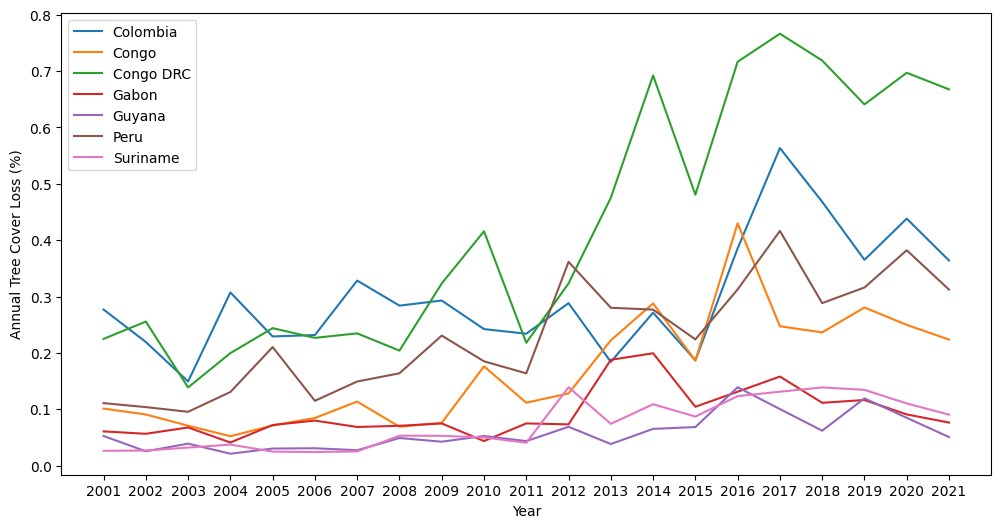

In [146]:
fig, ax = plt.subplots()
ax.set_ylabel('Annual Tree Cover Loss (%)')
for key, grp in main.groupby(['Country']):
    ax = grp.plot(ax=ax, kind='line', x='Year', y='Annual Tree Cover Loss', label=key, figsize=(12,6), xticks = [2000 + x for x in range(1,22)])

Below, we write functions to merge covariate data (mostly obtained directly or indirectly from the World Bank Statistical Database), with our existing time series in main.csv or main_cover.csv. The two different .csv files arose as a result of tests to switch the outcome variable to forest cover instead of deforestation rate, but eventually this was decided against. 

Note that in certain datasets Congo and Congo DRC. are referred to as Congo, Rep. and Congo, Dem. Rep. respectively. Thus, we have hardcoded switches to these in our functions to ensure that they are correctly recognised. 

Once again, the functions developed below are compiled into the script covariate_matching.py, which can be found in the scripts folder. 

In [99]:
def match_covariate(row, cov_df):
    '''
    Given a row from a pandas DataFrame as well as the relevant covariate
    DataFrame, this function matches the country in the row to its appropriate
    statistic in the covariate DataFrame.
    '''
    country = row['Country']
    year = row['Year']

    if country == 'Congo':
        country = 'Congo, Rep.'

    elif country == 'Congo DRC':
        country = 'Congo, Dem. Rep.'

    if str(year) in cov_df:
        if (cov_df[cov_df['Country Name'] == country][str(year)] != '..').iloc(0)[0]:
            return float(cov_df[cov_df['Country Name'] == country][str(year)])

def import_covariates(df, cov_dfs, cov_names):
    '''
    When matching multiple covariates, this function automatically matches and
    imports all of them into a provided DataFrame, df. It requires each of the
    covariate DataFrames as a list, cov_dfs, as well as the intended column
    names for the covariates as a list, cov_names. 
    '''
    for i, cov_df in enumerate(cov_dfs):
        df[cov_names[i]] = df.apply(
            match_covariate, axis=1, args=(cov_df,))
    
    return df

In [512]:
pop_growth = pd.read_csv('../data/covariates/population_growth_annual.csv')
ag_land = pd.read_csv('../data/covariates/agricultural_land.csv')
gdp_growth = pd.read_csv('../data/covariates/gdp_growth.csv')
for_rents = pd.read_csv('../data/covariates/forest_rents.csv')
min_rents = pd.read_csv('../data/covariates/mineral_rents.csv')
gov_eff = pd.read_csv('../data/covariates/gov_eff.csv')
pro_areas = pd.read_csv('../data/covariates/protected_areas.csv')
liv_index = pd.read_csv('../data/covariates/livestock_index.csv')
el_acc = pd.read_csv('../data/covariates/electricity_access.csv')

In [513]:
main = main.drop(columns=['Unnamed: 0', 'Forest Cover'])

When following the approach in Roopsind et al. 2019, we incorporate the same seven covariates used within that study: Population Growth, Agricultural Land, GDP Growth, Forest Rents, Mineral Rents, Government Effectiveness, and Protected Land Area. 

In [514]:
main = import_covariates(main, [pop_growth, ag_land, gdp_growth, for_rents, min_rents, gov_eff, pro_areas],
                  ['Population Growth', 'Agricultural Land', 'GDP Growth', 'Forest Rents', 'Mineral Rents', 'Government Effectiveness', 'Protected Area'])

In [515]:
roopsind_countries = ['Peru', 'Colombia', 'Suriname', 'Congo', 'Congo DRC', 'Guyana', 'Gabon']

In [516]:
main = main[main['Country'].isin(roopsind_countries)]

In [517]:
main

,Country,Year,Annual Tree Cover Loss,Population Growth,Agricultural Land,GDP Growth,Forest Rents,Mineral Rents,Government Effectiveness,Protected Area
0,Guyana,2001,0.052502,0.099812,5.716134,2.279522,8.490615,4.422916,NaN,4.987003
1,Guyana,2002,0.025239,0.067626,5.738694,1.132627,8.273747,4.511380,-0.179418,4.987003
2,Guyana,2003,0.038911,0.031429,5.761255,-0.632225,9.506019,7.442208,-0.022859,4.987003
3,Guyana,2004,0.020974,-0.018146,5.783815,1.563352,10.215034,10.984247,-0.040766,4.995118
4,Guyana,2005,0.030157,-0.094071,5.806375,-1.950958,10.624378,10.201725,-0.500309,5.004679
...,...,...,...,...,...,...,...,...,...,...
142,Congo DRC,2017,0.766448,3.442767,14.678106,3.726948,17.103966,7.001726,-1.634874,NaN
143,Congo DRC,2018,0.718888,3.272827,14.796321,5.821121,8.990381,8.011428,-1.539629,NaN
144,Congo DRC,2019,0.640969,3.186288,14.878366,4.384529,8.702887,4.321935,-1.618209,NaN
145,Congo DRC,2020,0.697155,3.224478,14.808672,1.735423,9.390393,4.993564,-1.714081,NaN


<h3> Synthetic Control generation </h3>

We generate the synthetic control for Guyana as shown below using the SyntheticControlMethods package. Inputs to instantiate a Synth class object include the appropriate DataFrame, object variable, treatment variabe, time variable, intervention time, and treatment unit. 

In [ ]:
sc = Synth(main, 'Annual Tree Cover Loss', 'Country', 'Year', 2011, 'Guyana')

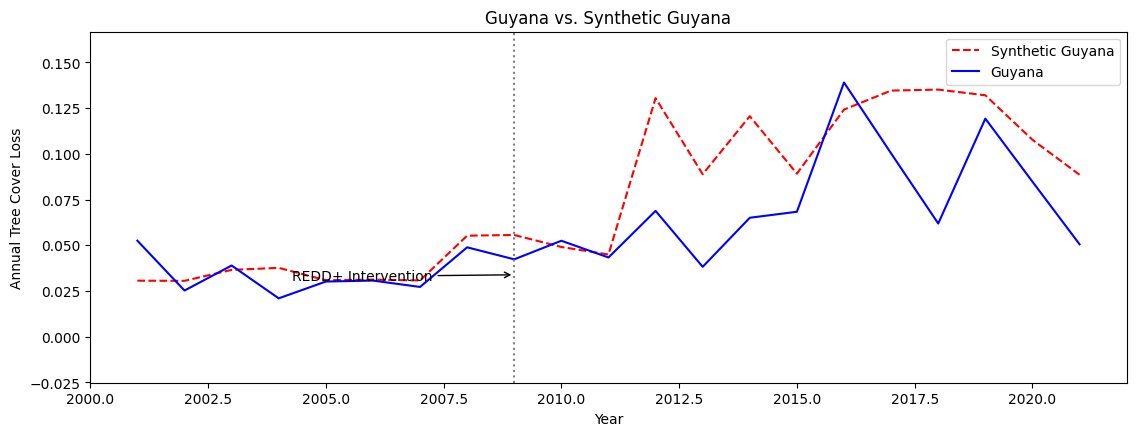

In [151]:
sc.plot(["original"], treated_label="Guyana", 
            synth_label="Synthetic Guyana", treatment_label="REDD+ Intervention", figsize=(12, 5))

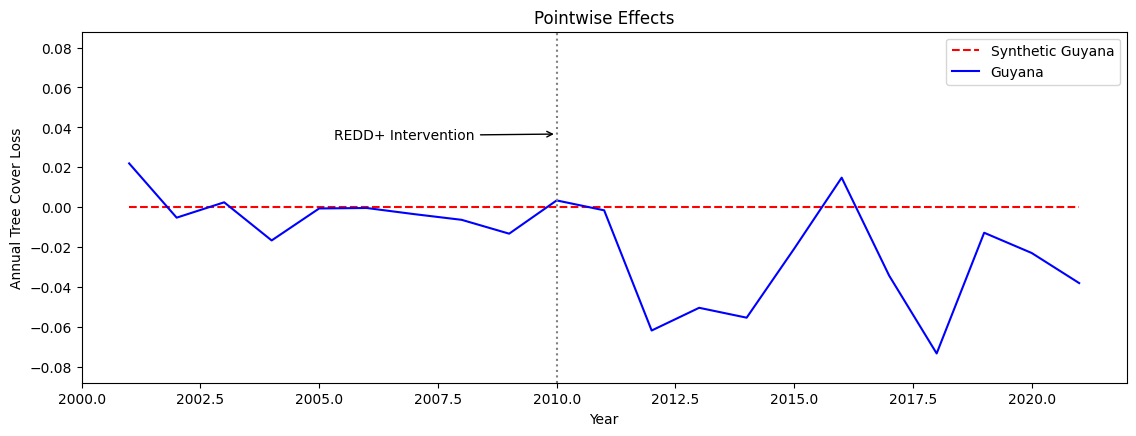

In [182]:
sc.plot(["pointwise"], treated_label="Guyana", 
            synth_label="Synthetic Guyana", treatment_label="REDD+ Intervention", figsize=(12, 5))

Running an in-space placebo allows for comparison with other units in the donor pool. Fundamentally, a higher post-intervention to pre-intervention RMSPE ratio will indicate a larger treatment effect. A significant effect will usually mean that the treated unit is very high on the list compared with donor pool countries. If countries in the donor pool have notably higher ratios than the treated country, that could indicate treatment contamination.

In [ ]:
sc.in_space_placebo()

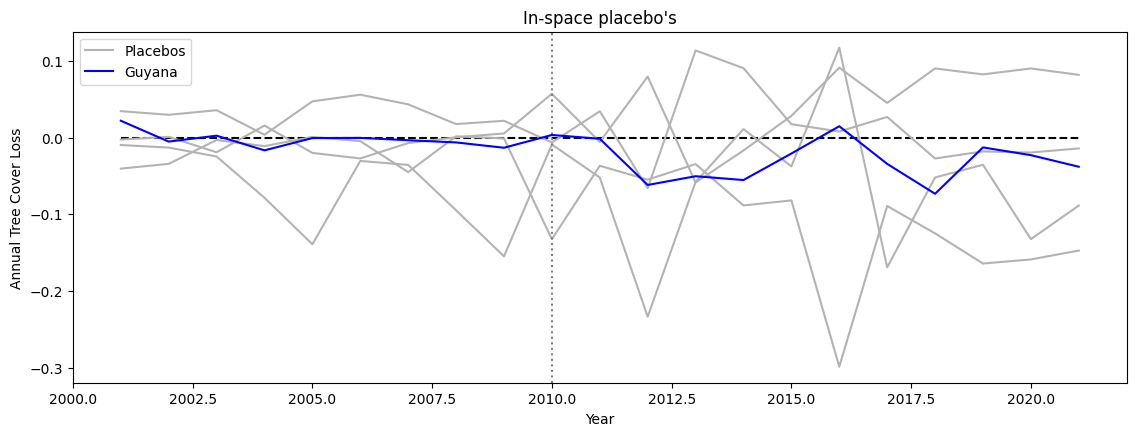

In [24]:
sc.plot(["in-space placebo"], treated_label="Guyana", 
            synth_label="Synthetic Guyana", treatment_label="REDD+ Intervention", figsize=(12, 5))

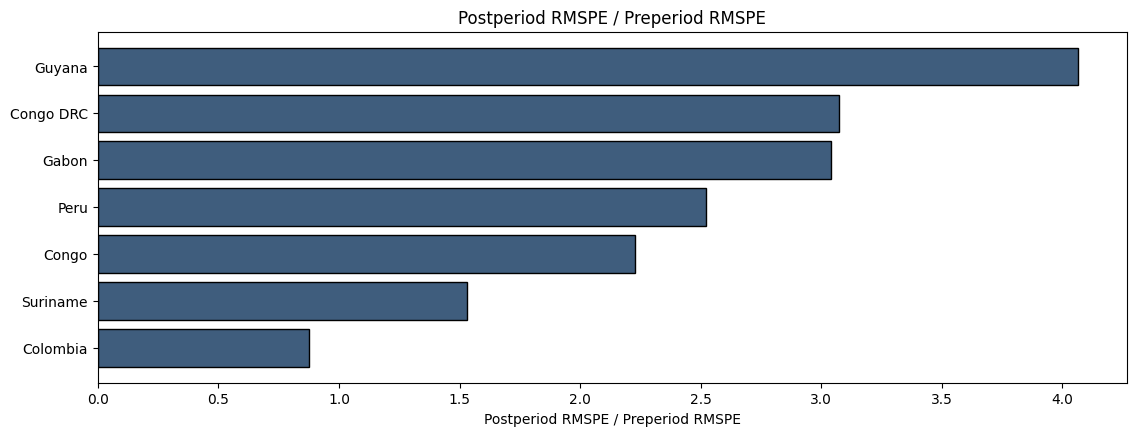

In [161]:
sc.plot(['rmspe ratio'], figsize = (12, 5))

In this case, Guyana is the highest among our placebos, indicating that the treatment effect observed is unlikely to be circumstantial. Next, we'll go ahead and incorporate the two covariates new to this study: livestock index and access to electricity. We'll then regenerate the synthetic control.

In [501]:
main = import_covariates(main, [pop_growth, ag_land, gdp_growth, for_rents, min_rents, gov_eff, pro_areas, liv_index, el_acc],
                  ['Population Growth', 'Agricultural Land', 'GDP Growth', 'Forest Rents', 'Mineral Rents', 'Government Effectiveness', 'Protected Area', 'Livestock Index', 'Electricity Access'])

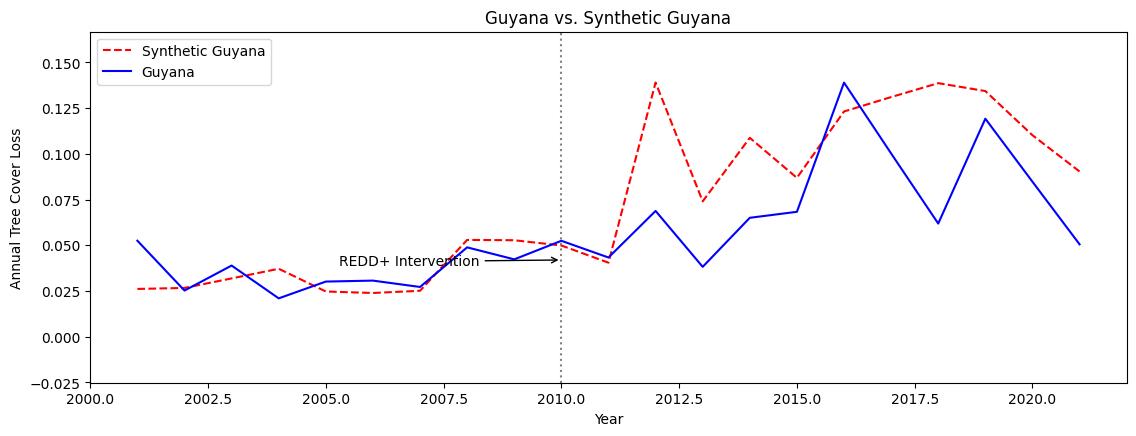

In [199]:
sc.plot(["original"], treated_label="Guyana", 
            synth_label="Synthetic Guyana", treatment_label="REDD+ Intervention", figsize = (12,5))

<h3> Synthetic Controls for Honduras and Gabon </h3>

We're also interested in synthetic controls for Honduras and Gabon, which we'll run below. Note that for these, we ran the pipeline above without limiting the set to only countries featured in Roopsind et al. 2019, meaning that the donor pool here is a total of 17 countries. 

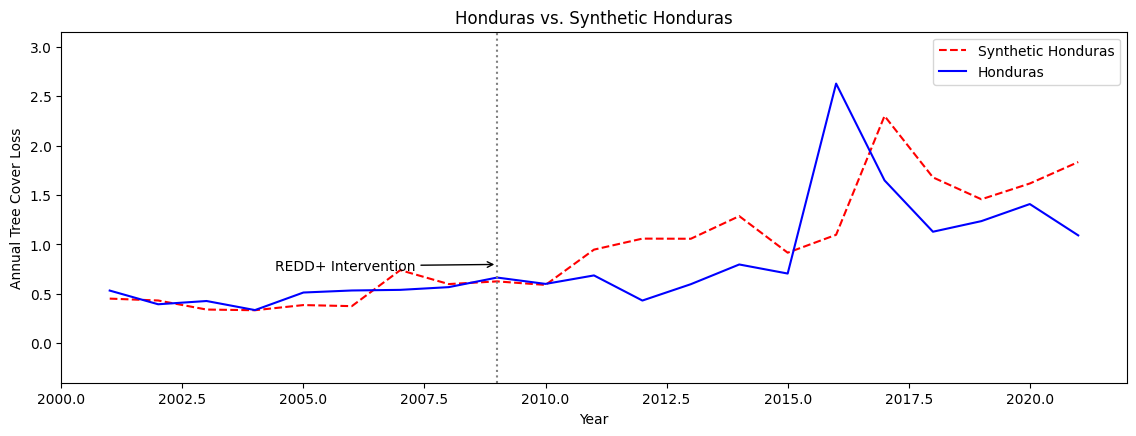

In [109]:
sc.plot(["original"], treated_label="Honduras", 
            synth_label="Synthetic Honduras", treatment_label="REDD+ Intervention", figsize=(12, 5))

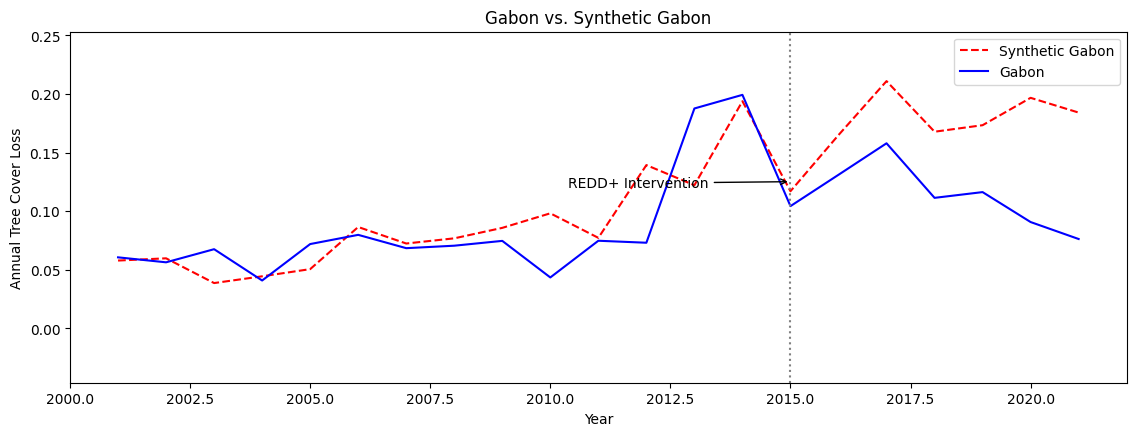

In [111]:
sc.plot(["original"], treated_label="Gabon", 
            synth_label="Synthetic Gabon", treatment_label="REDD+ Intervention", figsize=(12, 5))

In [ ]:
sc.in_space_placebo()

<h3> Differentiated Synthetic Controls </h3>

Here, we test out differentiated synthetic controls, an alternative form of synthetic controls which do not require weights to sum up to 1, allowing for additional flexibility. Note that these were not included in the final study due to time constraints, but present similar conclusions in terms of additionalities in Guyana over the long term. 

In [ ]:
dsc = DiffSynth(main, 'Annual Tree Cover Loss',
           'Country', 'Year', 2010, 'Guyana')

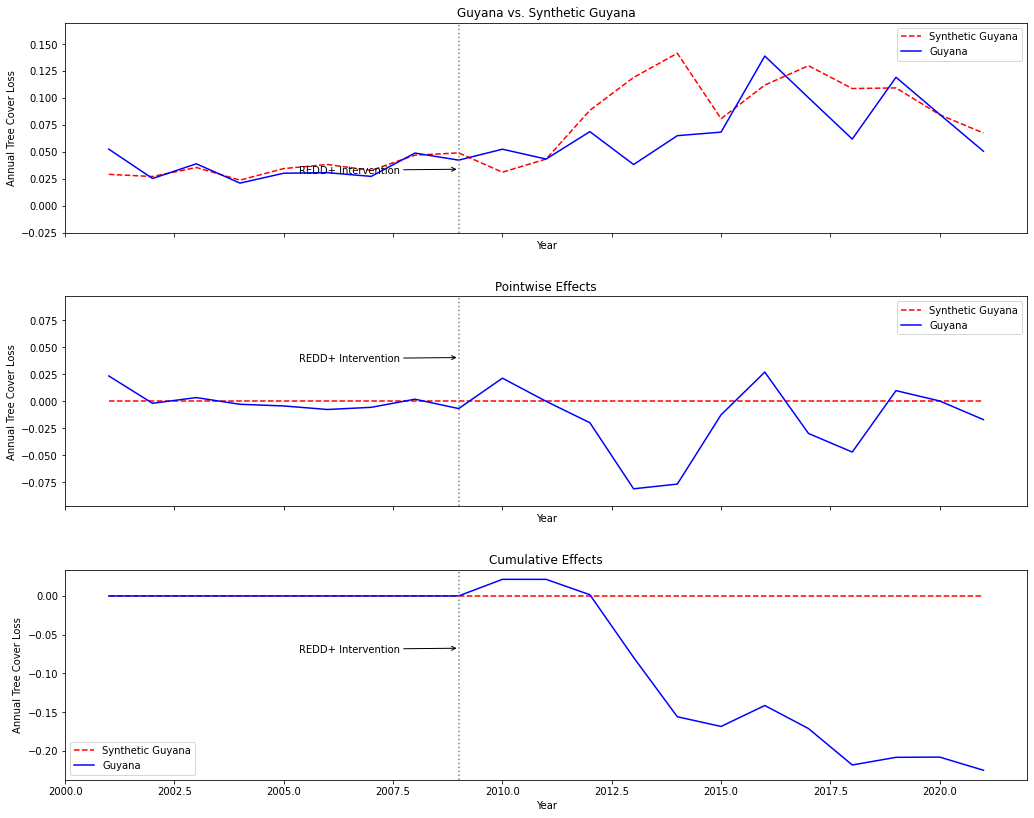

In [25]:
dsc.plot(["original", "pointwise", "cumulative"], treated_label="Guyana", 
            synth_label="Synthetic Guyana", treatment_label="REDD+ Intervention")

In [26]:
dsc.original_data.weight_df

,Weight
Suriname,0.468251
Gabon,0.531749


In [28]:
dsc.original_data.comparison_df

,Guyana,Synthetic Guyana,WMAPE,Importance
Annual Tree Cover Loss,-0.00,0.00,0.02,0.04
Population Growth,-0.14,2.17,2.28,0.60
Agricultural Land,5.82,4.55,3.72,0.13
GDP Growth,2.23,2.71,2.01,0.23
Forest Rents,7.58,2.02,5.63,0.00
Mineral Rents,6.59,1.87,4.55,0.00


<h3> Multidimensional Scaling for Countries </h3>

To get a better sense of how our countries stand relative to each other across the outcome variable and covariates, we plot out a 2 dimensional grid after running sklearn.manifold.MDS on our data. 

In [261]:
mds_test = main.set_index('Country').groupby('Country').mean().drop(columns='Year')

In [265]:
mds_test = mds_test.drop(columns='Energy Use')

In [324]:
mds_test

,Annual Tree Cover Loss,Population Growth,Agricultural Land,GDP Growth,Forest Rents,Mineral Rents,Government Effectiveness,Protected Area,Livestock Index
Country,,,,,,,,,
Cameroon,0.273747,2.804898,20.107994,3.990457,2.772060,0.038927,-0.862211,9.487984,95.037619
Central African Republic,0.101691,1.774901,8.233089,1.403779,10.479933,0.030089,-1.556823,17.785490,90.763810
Colombia,0.300429,1.299241,39.787139,3.662428,0.133492,0.515699,-0.106718,20.504865,91.600000
Congo,0.167009,2.960441,30.998389,1.704129,3.599621,0.007352,-1.234788,13.252015,84.816667
Congo DRC,0.422091,3.234693,12.867978,5.245995,17.371892,4.315208,-1.629719,10.360692,97.474286
Gabon,0.093192,2.901569,8.293939,2.273111,2.874357,0.027589,-0.789895,15.126299,94.161429
Guyana,0.057551,0.277311,6.010159,5.790165,6.521300,6.210244,-0.209380,5.036705,89.868095
Honduras,0.831740,2.068627,29.327464,3.716740,1.341391,0.191591,-0.670770,18.703597,95.442857
Kenya,0.858429,2.577186,48.032031,4.416542,2.906667,0.026011,-0.530238,11.727693,93.380952


In [266]:
mds = MDS(random_state=0)
scaled_df = mds.fit_transform(mds_test)

/Users/onkar/Documents/AI4ER/MRes Project/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


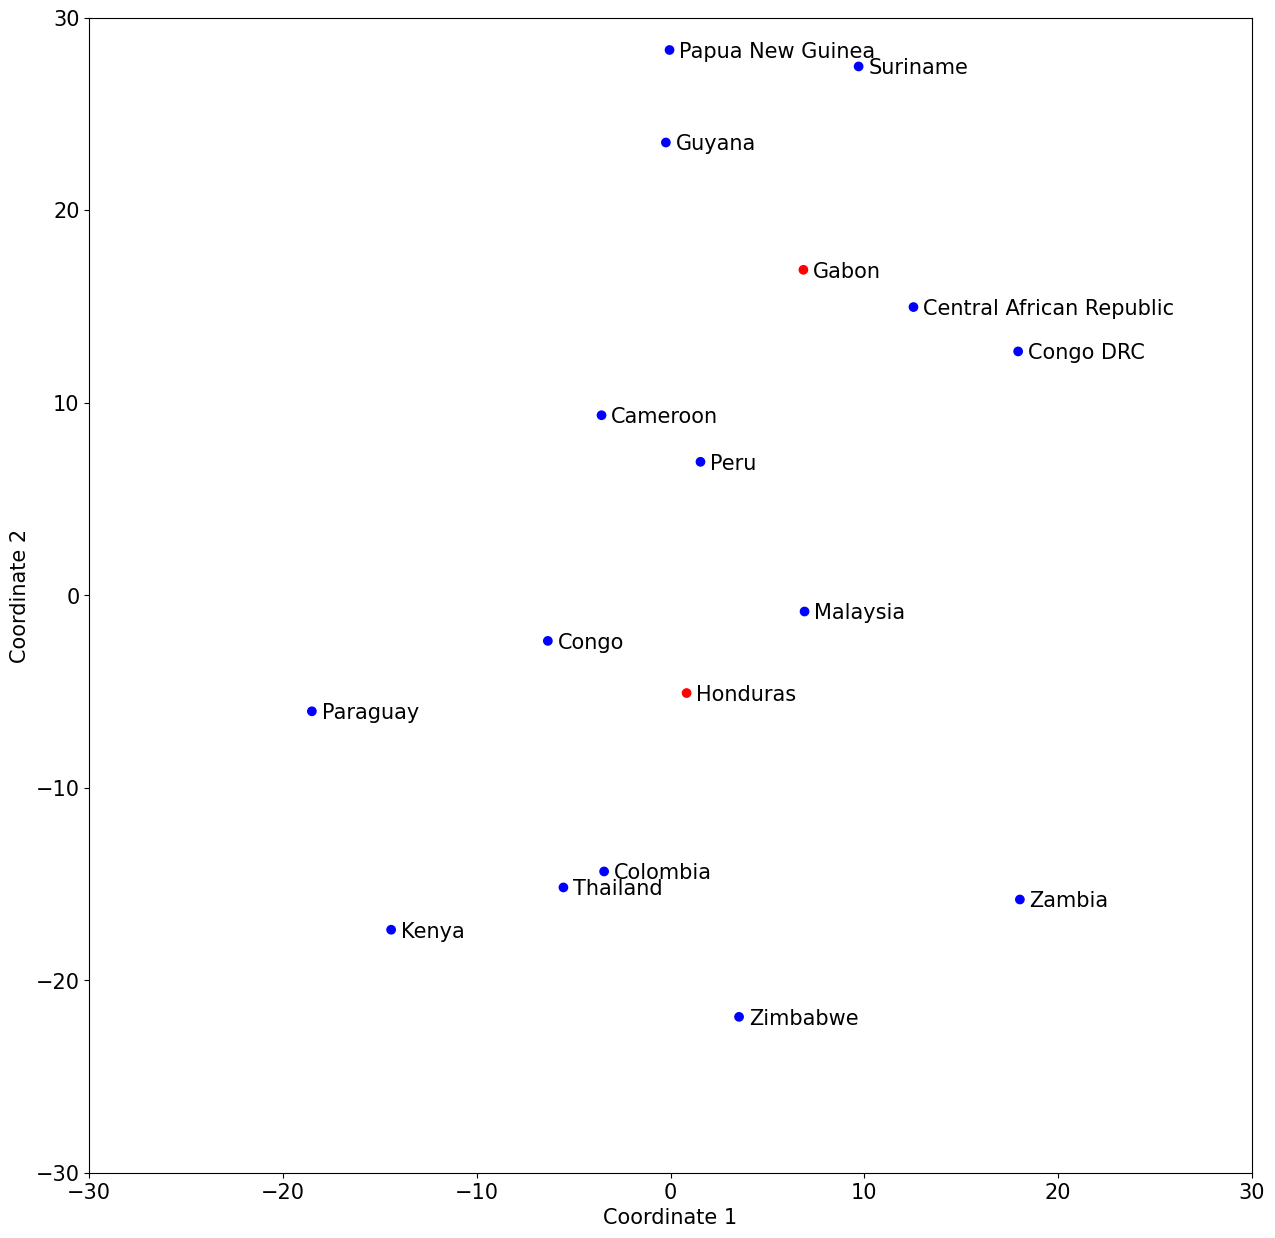

In [496]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (15,15))
colors = ['b'] * 18
colors[7], colors[5] = 'r', 'r'
plt.scatter(scaled_df[:,0], scaled_df[:,1], c = colors)

plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.xlim((-30, 30))
plt.ylim((-30,30))

for i, txt in enumerate(mds_test.index):
    plt.annotate(txt, (scaled_df[:,0][i]+0.5, scaled_df[:,1][i]-0.4))

plt.show()